## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [4]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file 
f = open('../Data/complaints-2021-05-14_08_16.json',)# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [6]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
print("Shape of the dataframe:", df.shape)

Shape of the dataframe: (78313, 22)


In [8]:
#print the column names
for col in df.columns:
    print(col)

_index
_type
_id
_score
_source.tags
_source.zip_code
_source.complaint_id
_source.issue
_source.date_received
_source.state
_source.consumer_disputed
_source.product
_source.company_response
_source.company
_source.submitted_via
_source.date_sent_to_company
_source.company_public_response
_source.sub_product
_source.timely
_source.complaint_what_happened
_source.sub_issue
_source.consumer_consent_provided


In [9]:
#Assign new column names
df.rename(columns={'_index':'index',
                   '_type':'type',
                   '_id':'id',
                   '_score':'score',
                   '_source.tags':'tags',
                   '_source.zip_code':'zip_code',
                   '_source.complaint_id':'complaint_id',
                   '_source.issue':'issue',
                   '_source.date_received':'date_received',
                   '_source.state':'state',
                   '_source.consumer_disputed':'consumer_disputed',
                   '_source.product':'product',
                   '_source.company_response':'company_response',
                   '_source.company':'company',
                   '_source.submitted_via':'submitted_via',
                   '_source.date_sent_to_company':'date_sent_to_company',
                   '_source.company_public_response':'company_public_response',
                   '_source.sub_product':'sub_product',
                   '_source.timely':'timely',
                   '_source.complaint_what_happened':'complaint_what_happened',
                   '_source.sub_issue':'sub_issue',
                   '_source.consumer_consent_provided':'consumer_consent_provided'
                  }, inplace=True)

In [10]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [11]:
#Count blank counts in complaint column
#Out of total 78313 rows, blank complaints count is 57241
len(df[df['complaint_what_happened'] == ''])

57241

In [12]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'', np.NaN)
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,NaN,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,NaN,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,NaN,Charged too much interest,N/A


In [13]:
#Remove all rows where complaints column is nan
df = df[pd.notnull(df['complaint_what_happened'])]
df.shape

(21072, 22)

In [14]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
     text = text.lower()
    text = re.sub("\[.*?]|[^\w\s]|\w*\d\w*", "", text)
    return text

df.complaint_what_happened = pd.DataFrame(df.complaint_what_happened.apply(lambda x: clean_text(x)))

In [16]:
df.head(50)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided
15,complaint-public-v2,complaint,3209411,0.0,None,None,3209411,Improper use of your report,2019-04-11T12:00:00-05:00,LA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-11T12:00:00-05:00,None,Credit reporting,Yes,can you please remove inquiry,Credit inquiries on your report that you don't...,Consent provided
17,complaint-public-v2,complaint,3331023,0.0,None,770XX,3331023,Closing an account,2019-08-06T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-06T12:00:00-05:00,None,Checking account,Yes,with out notice jp morgan chase restricted my ...,Funds not received from closed account,Consent provided
20,complaint-public-v2,complaint,3352857,0.0,None,207XX,3352857,Struggling to pay your loan,2019-08-24T12:00:00-05:00,MD,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-08-24T12:00:00-05:00,None,Loan,Yes,during the summer months i experience a declin...,Denied request to lower payments,Consent provided
21,complaint-public-v2,complaint,3226110,0.0,Servicemember,846XX,3226110,Fraud or scam,2019-04-29T12:00:00-05:00,UT,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-29T12:00:00-05:00,None,Domestic (US) money transfer,Yes,on xxxx i made a payment to an online retail...,None,Consent provided
23,complaint-public-v2,complaint,3237765,0.0,None,330XX,3237765,Incorrect information on your report,2019-05-09T12:00:00-05:00,FL,...,Closed with non-monetary relief,JPMORGAN CHASE & CO.,Web,2019-05-09T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i have a chase credit card which is incorrectl...,Account information incorrect,Consent provided


In [17]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
#nltk.download('wordnet')
#nltk.download('stopwords')

In [18]:
#Write your function to Lemmatize the texts
def lemmatizer(text):        
    sent = [wordnet_lemmatizer.lemmatize(word) for word in text.split() if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [19]:
df['complaint_with_Lema'] =  df.complaint_what_happened.apply(lambda x: lemmatizer(x))

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_what_happened','complaint_with_Lema']]

In [21]:
df_clean

,complaint_what_happened,complaint_with_Lema
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...


In [22]:
#Write your function to extract the POS tags NN (Only NN tagged words will remain)

def pos_filter(text):
    str = []
    model = spacy.load("en_core_web_sm")
    tokens = model(text)
    for token in tokens:
        if token.tag_ in "NN":
            str.append(token.text)
    return " ".join(str)

In [23]:
df_clean['complaint_POS_removed'] =  df_clean.complaint_with_Lema.apply(lambda x: pos_filter(x))

In [24]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_with_Lema,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase debt verific...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,application identity consent service extend cr...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account account money ...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,card customer well decade solicitation credit ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,visa credit provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase year trust banking de...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([6.764e+03, 6.328e+03, 3.487e+03, 1.780e+03, 9.680e+02, 7.370e+02,
        4.380e+02, 1.660e+02, 9.000e+01, 7.000e+01, 4.600e+01, 3.900e+01,
        2.700e+01, 2.200e+01, 2.500e+01, 1.200e+01, 1.400e+01, 5.000e+00,
        8.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([    0. ,   615.6,  1231.2,  1846.8,  2462.4,  3078. ,  3693.6,
         4309.2,  4924.8,  5540.4,  6156. ,  6771.6,  7387.2,  8002.8,
         8618.4,  9234. ,  9849.6, 10465.2, 11080.8, 11696.4, 12312. ,
        12927.6, 13543.2, 14158.8, 14774.4, 15390. , 16005.6, 16621.2,
        17236.8, 17852.4, 18468. , 19083.6, 19699.2, 20314.8, 20930.4,
        21546. , 2216

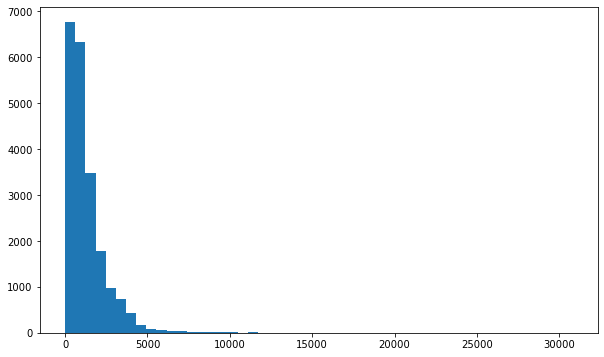

In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_what_happened]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

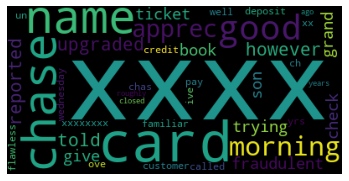

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud
from wordcloud import WordCloud
stoplist = set(stopwords.words("english"))


wordcloud = WordCloud(stopwords=stoplist,max_words=40).generate(str(df_clean.complaint_what_happened))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [28]:
df_clean

,complaint_what_happened,complaint_with_Lema,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase debt verific...,morning name xxxx xxxx stop chase debt verific...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,application identity consent service extend cr...,application identity consent service extend cr...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book xxxx xxxx ticket offer ticket reward card...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,card customer well decade solicitation credit ...,card customer well decade solicitation credit ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,visa credit provider claim purchase protection...,visa credit provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase year trust banking de...,xxxx risk consumer chase year trust banking de...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
#Print the top 10 words in the unigram frequency
unigram_words = get_top_n_unigram(df_clean.complaint_what_happened, 10)
unigram_df = pd.DataFrame(unigram_words, columns = ['unigram' , 'count'])
unigram_df

,unigram,count
0,xxxx,192544
1,chase,79843
2,account,42584
3,credit,32671
4,xxxxxxxx,27915
5,card,26838
6,bank,26643
7,told,16377
8,did,15986
9,payment,13964


In [36]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [37]:
#Print the top 10 words in the bigram frequency
bigram_words = get_top_n_bigram(df_clean.complaint_what_happened, 10)
bigram_df = pd.DataFrame(bigram_words, columns = ['bigram' , 'count'])
bigram_df

,bigram,count
0,xxxx xxxx,83065
1,chase bank,12605
2,credit card,10903
3,xxxx chase,3942
4,called chase,3688
5,checking account,3550
6,credit report,3237
7,xxxxxxxx xxxx,3199
8,customer service,3014
9,xxxx xxxxxxxx,2939


In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [39]:
#Print the top 10 words in the trigram frequency
trigram_words = get_top_n_trigram(df_clean.complaint_what_happened, 10)
trigram_df = pd.DataFrame(trigram_words, columns = ['trigram' , 'count'])
trigram_df

,trigram,count
0,xxxx xxxx xxxx,39225
1,jp morgan chase,2339
2,chase credit card,1810
3,xxxx xxxx chase,1653
4,xxxxxxxx xxxx xxxx,1593
5,xxxx xxxx xxxxxxxx,1289
6,chase xxxx xxxx,1146
7,chase bank xxxx,982
8,xxxx xxxxxxxx xxxx,964
9,account xxxx xxxx,912


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [40]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [41]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_with_Lema,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase debt verific...,morning name stop chase debt verification st...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,application identity consent service extend cr...,application identity consent service extend cr...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,book xxxx xxxx ticket offer ticket reward card...,book ticket offer ticket reward card informa...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,son check deposit chase account account money ...,son check deposit chase account account money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,card customer well decade solicitation credit ...,card customer well decade solicitation credit ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,visa credit provider claim purchase protection...,visa credit provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase year trust banking de...,risk consumer chase year trust banking deal m...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom prob...,credit yr chase credit card chase freedom prob...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 2 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



